This is Week 5 homework from [Winter 2020 of Statistical Rethinking](https://github.com/rmcelreath/stat_rethinking_2020/tree/main/homework) using Python. A public repo using `pmyc3` has been created [here](https://github.com/pymc-devs/resources/tree/master/Rethinking_2) that also uses Python. It will helpful for me to do these exercises myself, but that repo will serve as a helpful reference.

In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pymc3 as pm
import scipy.stats as stats
import seaborn as sns

from scipy.optimize import curve_fit

In [2]:
%load_ext nb_black
%config InlineBackend.figure_format = 'retina'
%load_ext watermark
RANDOM_SEED = 8927
np.random.seed(RANDOM_SEED)
az.style.use("arviz-darkgrid")
az.rcParams["stats.hdi_prob"] = 0.89  # sets default credible interval used by arviz

<IPython.core.display.Javascript object>

In [3]:
sns.set_context("talk")

<IPython.core.display.Javascript object>

# Question 1 (8H5)

Consider the data(Wines2012) data table. These data are expert ratings
of 20 different French and American wines by 9 different French and American
judges. Your goal is to model score, the subjective rating assigned by
each judge to each wine. I recommend standardizing it.
In this first problem, consider only variation among judges and wines.
Construct index variables of judge and wine and then use these index variables
to construct a linear regression model. Justify your priors. You should
end up with 9 judge parameters and 20 wine parameters. Use ulam instead
of quap to build this model, and be sure to check the chains for convergence.
If you’d rather build the model directly in Stan or PyMC3 or Julia (Turing is
a good choice!), go ahead. I just want you to use MCMC instead of quadratic
approximation.
How do you interpret the variation among individual judges and individual
wines? Do you notice any patterns, just by plotting the differences?
Which judges gave the highest/lowest ratings? Which wines were rated worst/
best on average?

In [4]:
os.getcwd()

'/Users/blacar/Documents/ds_projects/stats_rethinking/repo'

<IPython.core.display.Javascript object>

In [5]:
def standardize(x):
    x = (x - np.mean(x)) / np.std(x)
    return x

<IPython.core.display.Javascript object>

## Data exploration and setup

In [6]:
# df_wines = pd.read_csv(
#     "https://github.com/rmcelreath/rethinking/tree/master/data/Wines2012.csv",
#     delimiter=";",
#     header=0,
# )
df_wines = pd.read_csv("other_data/Wines2012.csv")
df_wines["score_std"] = standardize(df_wines["score"])
df_wines.head()

,judge,flight,wine,score,wine.amer,judge.amer,score_std
0,Jean-M Cardebat,white,A1,10.0,1,0,-1.581002
1,Jean-M Cardebat,white,B1,13.0,1,0,-0.451715
2,Jean-M Cardebat,white,C1,14.0,0,0,-0.075286
3,Jean-M Cardebat,white,D1,15.0,0,0,0.301143
4,Jean-M Cardebat,white,E1,8.0,1,0,-2.333860


<IPython.core.display.Javascript object>

In [7]:
df_wines["judge"].unique()

array(['Jean-M Cardebat', 'Tyler Colman', 'John Foy', 'Olivier Gergaud',
       'Robert Hodgson', 'Linda Murphy', 'Daniele Meulder',
       'Jamal Rayyis', 'Francis Schott'], dtype=object)

<IPython.core.display.Javascript object>

In [8]:
df_wines["wine"].unique()

array(['A1', 'B1', 'C1', 'D1', 'E1', 'F1', 'G1', 'H1', 'I1', 'J1', 'A2',
       'B2', 'C2', 'D2', 'E2', 'F2', 'G2', 'H2', 'I2', 'J2'], dtype=object)

<IPython.core.display.Javascript object>

/Users/blacar/opt/anaconda3/envs/stats_rethinking/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  self.fig.tight_layout(*args, **kwargs)


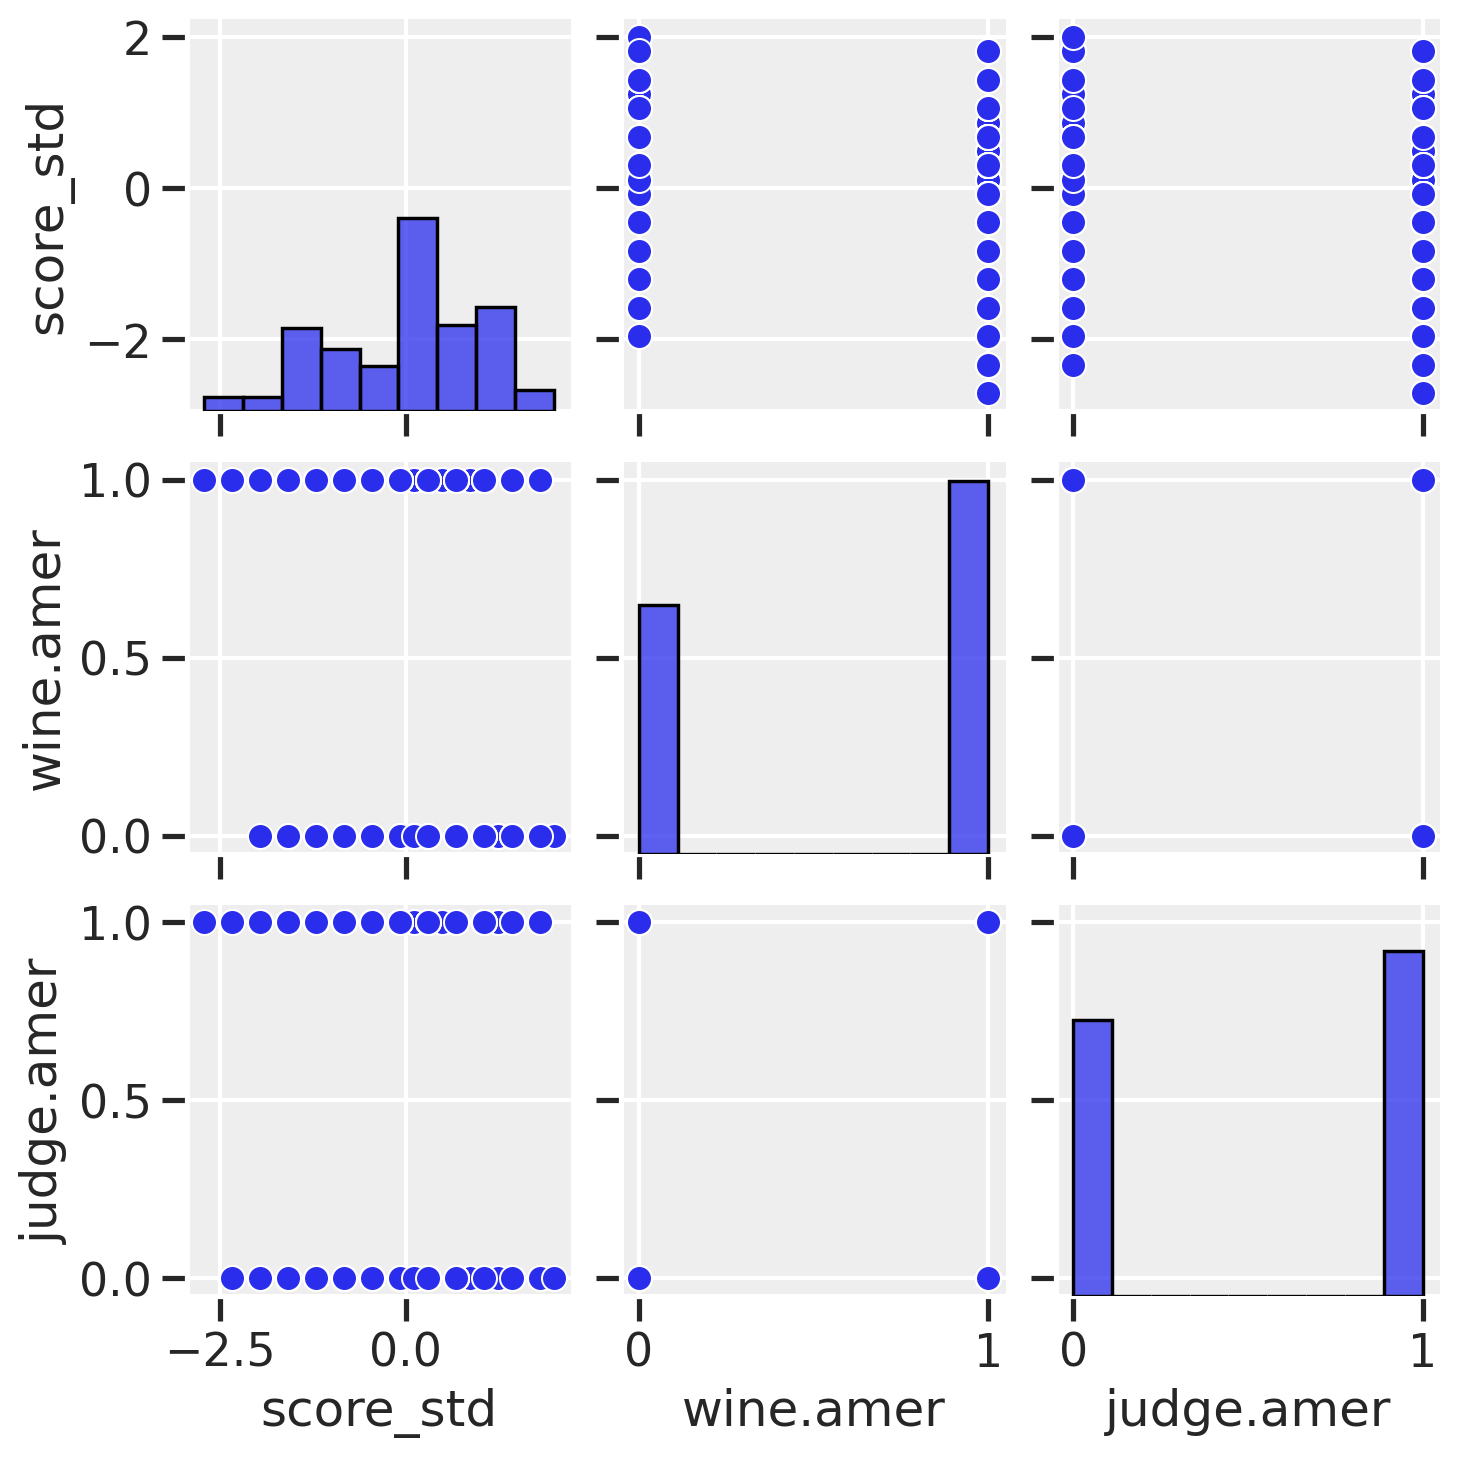

<IPython.core.display.Javascript object>

In [9]:
sns.pairplot(df_wines[["score_std", "wine.amer", "judge.amer"]])

### My approach

- Create index variables for `judge` and `wine`.
- Create a linear model that uses these index variables only.
- Inspect the summary.

### Create index variables

#### Manual method

In [10]:
judge_dict = dict()
count = 0
for judge in sorted(df_wines["judge"].unique()):
    judge_dict[judge] = count
    count += 1

<IPython.core.display.Javascript object>

In [11]:
wine_dict = dict()
count = 0
for wine in sorted(df_wines["wine"].unique()):
    wine_dict[wine] = count
    count += 1

<IPython.core.display.Javascript object>

In [12]:
df_wines["judge_index"] = df_wines["judge"].copy().replace(judge_dict)
df_wines["wine_index"] = df_wines["wine"].copy().replace(wine_dict)

<IPython.core.display.Javascript object>

#### Using `pandas.Categorical`

[Documentation](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Categorical.html) states that the values assigned will be sorted by unique values if possible.

In [13]:
df_wines["judge_index"] = pd.Categorical(df_wines["judge"]).codes
df_wines["wine_index"] = pd.Categorical(df_wines["wine"]).codes

df_wines.head()

,judge,flight,wine,score,wine.amer,judge.amer,score_std,judge_index,wine_index
0,Jean-M Cardebat,white,A1,10.0,1,0,-1.581002,3,0
1,Jean-M Cardebat,white,B1,13.0,1,0,-0.451715,3,2
2,Jean-M Cardebat,white,C1,14.0,0,0,-0.075286,3,4
3,Jean-M Cardebat,white,D1,15.0,0,0,0.301143,3,6
4,Jean-M Cardebat,white,E1,8.0,1,0,-2.333860,3,8


<IPython.core.display.Javascript object>

## Linear model 1a

Even though judge and wine are both categorical variables, the model is built similarly, using index notation. The score is standardized in this case. Since we have two categorical, and only categorical, variables, we don't need a separate intersect (alpha) term.

\(\text{score}_i$ ~ Normal($\mu_i, \sigma\))
<br>
\(\mu_i = judge_i[i] + wine_i[j]\)
<br>
\(judge\) ~ \(\text{Normal}(0, 2)\)
<br>
\(wine\) ~ \(\text{Normal}(0, 2)\)
<br>
\(\sigma\) ~ \(\text{Exp}(1)\)

To create the model with two categorical variables and using the index variable approach, I referenced page 158, R code 5.54 and also the [chapter 5 pymc repo](https://github.com/pymc-devs/resources/blob/master/Rethinking_2/Chp_05.ipynb) which is shown below.

```
with pm.Model() as m5_10:
    sigma = pm.Exponential("sigma", 1)
    mu_house = pm.Normal("mu_house", 0, 0.5, shape=d["house"].max() + 1)
    mu_clade = pm.Normal("mu_clade", 0, 0.5, shape=d["clade_id"].max() + 1)
    mu = mu_clade[d["clade_id"].values] + mu_house[d["house"].values]

    K = pm.Normal("K", mu, sigma, observed=d["K"])

    m5_9_trace = pm.sample()

az.summary(m5_9_trace, var_names=["mu_clade", "mu_house"])
```

I was curious about the shape parameter and found [this discussion](https://discourse.pymc.io/t/pm-normal-what-is-the-shape-parameter-for-a-normal-distribution/1851). It is basically the number of unique values for that category.

### Testing chains/cores setting

One of the things that I can leverage with my hardware is the number of cores. It can be discovered on my Mac [through the GUI interface](https://support.macincloud.com/support/solutions/articles/8000087401-how-to-check-the-number-of-cpu-cores-on-a-mac#:~:text=To%20review%20the%20total%20number,%22Number%20of%20Processors%22%20number.) or by the [command line](https://stackoverflow.com/questions/1715580/how-to-discover-number-of-logical-cores-on-mac-os-x). Note that this command line query provides the number of logical cores that I can run while the report by the GUI (8) is the number of physical cores.

In [14]:
!sysctl -n hw.ncpu

16


<IPython.core.display.Javascript object>

In [19]:
import time

print(time.time())

1623079281.1602628


<IPython.core.display.Javascript object>

In [20]:
start_time = time.time()
with pm.Model() as wine_model_coretest0:

    # Priors are variables judge, wine (kind of like alpha) and sigma
    # the shape parameter is a way to get multiple indexes represented
    judge = pm.Normal("judge", mu=0, sd=2, shape=len(df_wines["judge_index"].unique()))
    wine = pm.Normal("wine", mu=0, sd=2, shape=len(df_wines["wine_index"].unique()))
    sigma = pm.Exponential("sigma", 1)

    # Linear model
    mu = judge[df_wines["judge_index"].values] + wine[df_wines["wine_index"].values]

    # Likelihood is score_std variable, which is also observed
    s = pm.Normal("s", mu=mu, sd=sigma, observed=df_wines["score_std"])

    # Fitting and sampling all at once.
    trace0 = pm.sample(1000, tune=1000, return_inferencedata=True, chains=1, cores=1)

end_time = time.time()
print("chains=1, cores=1: ", end_time - start_time)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma, wine, judge]


/Users/blacar/opt/anaconda3/envs/stats_rethinking/lib/python3.8/site-packages/pymc3/math.py:246: RuntimeWarning: divide by zero encountered in log1p
  return np.where(x < 0.6931471805599453, np.log(-np.expm1(-x)), np.log1p(-np.exp(-x)))
Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 3 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


chains=1, cores=1:  9.066642999649048


<IPython.core.display.Javascript object>

In [21]:
# see what happens with ess_mean, ess_sd with one chain
az.summary(trace0)

arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
judge[0],-0.224,0.397,-0.833,0.406,0.041,0.029,94.0,94.0,95.0,198.0,NaN
judge[1],0.331,0.404,-0.331,0.924,0.042,0.030,93.0,93.0,95.0,172.0,NaN
judge[2],0.318,0.406,-0.252,1.034,0.042,0.030,93.0,93.0,94.0,208.0,NaN
judge[3],-0.520,0.411,-1.195,0.086,0.043,0.031,90.0,90.0,91.0,184.0,NaN
judge[4],1.000,0.406,0.310,1.594,0.042,0.030,93.0,93.0,95.0,155.0,NaN
judge[5],0.631,0.408,-0.052,1.207,0.042,0.030,93.0,93.0,95.0,185.0,NaN
judge[6],0.235,0.408,-0.419,0.869,0.043,0.030,92.0,92.0,93.0,193.0,NaN
judge[7],-0.657,0.408,-1.282,-0.022,0.043,0.031,88.0,88.0,89.0,178.0,NaN
judge[8],-0.307,0.407,-0.965,0.315,0.042,0.030,95.0,95.0,97.0,158.0,NaN
wine[0],0.075,0.449,-0.660,0.750,0.044,0.031,106.0,106.0,108.0,243.0,NaN


<IPython.core.display.Javascript object>

In [127]:
start_time = time.time()
with pm.Model() as wine_model_coretest1:

    # Priors are variables judge, wine (kind of like alpha) and sigma
    # the shape parameter is a way to get multiple indexes represented
    judge = pm.Normal("judge", mu=0, sd=2, shape=len(df_wines["judge_index"].unique()))
    wine = pm.Normal("wine", mu=0, sd=2, shape=len(df_wines["wine_index"].unique()))
    sigma = pm.Exponential("sigma", 1)

    # Linear model
    mu = judge[df_wines["judge_index"].values] + wine[df_wines["wine_index"].values]

    # Likelihood is score_std variable, which is also observed
    s = pm.Normal("s", mu=mu, sd=sigma, observed=df_wines["score_std"])

    # Fitting and sampling all at once.
    trace1 = pm.sample(1000, tune=1000, return_inferencedata=True, chains=2, cores=1)

end_time = time.time()
print("chains=1, cores=1: ", end_time - start_time)

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
INFO:pymc3:Sequential sampling (2 chains in 1 job)
NUTS: [sigma, wine, judge]
INFO:pymc3:NUTS: [sigma, wine, judge]


/Users/blacar/opt/anaconda3/envs/stats_rethinking/lib/python3.8/site-packages/pymc3/math.py:246: RuntimeWarning: divide by zero encountered in log1p
  return np.where(x < 0.6931471805599453, np.log(-np.expm1(-x)), np.log1p(-np.exp(-x)))


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 4 seconds.
INFO:pymc3:Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 4 seconds.
The estimated number of effective samples is smaller than 200 for some parameters.
ERROR:pymc3:The estimated number of effective samples is smaller than 200 for some parameters.


chains=1, cores=1:  6.5018229484558105


<IPython.core.display.Javascript object>

In [128]:
# see what happens with ess_mean, ess_sd with two chains
az.summary(trace1)

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
judge[0],-0.408,0.430,-1.045,0.306,0.043,0.031,100.0,100.0,100.0,221.0,1.04
judge[1],0.153,0.430,-0.519,0.820,0.044,0.031,95.0,95.0,96.0,166.0,1.04
judge[2],0.144,0.431,-0.550,0.788,0.043,0.031,100.0,100.0,100.0,219.0,1.04
judge[3],-0.702,0.431,-1.385,-0.019,0.043,0.031,99.0,99.0,100.0,211.0,1.04
judge[4],0.811,0.427,0.203,1.555,0.043,0.031,97.0,97.0,98.0,216.0,1.04
judge[5],0.456,0.431,-0.173,1.175,0.043,0.031,98.0,98.0,99.0,214.0,1.04
judge[6],0.064,0.425,-0.601,0.735,0.044,0.031,96.0,96.0,96.0,196.0,1.04
judge[7],-0.836,0.427,-1.504,-0.183,0.043,0.031,96.0,96.0,97.0,197.0,1.04
judge[8],-0.480,0.433,-1.119,0.261,0.043,0.031,99.0,99.0,99.0,214.0,1.04
wine[0],0.239,0.481,-0.551,0.964,0.044,0.031,122.0,122.0,122.0,231.0,1.03


<IPython.core.display.Javascript object>

In [123]:
start_time = time.time()
with pm.Model() as wine_model_coretest1:

    # Priors are variables judge, wine (kind of like alpha) and sigma
    # the shape parameter is a way to get multiple indexes represented
    judge = pm.Normal("judge", mu=0, sd=2, shape=len(df_wines["judge_index"].unique()))
    wine = pm.Normal("wine", mu=0, sd=2, shape=len(df_wines["wine_index"].unique()))
    sigma = pm.Exponential("sigma", 1)

    # Linear model
    mu = judge[df_wines["judge_index"].values] + wine[df_wines["wine_index"].values]

    # Likelihood is score_std variable, which is also observed
    s = pm.Normal("s", mu=mu, sd=sigma, observed=df_wines["score_std"])

    # Fitting and sampling all at once.
    trace1 = pm.sample(1000, tune=1000, return_inferencedata=True, chains=2, cores=16)

end_time = time.time()
print("chains=2, cores=16: ", end_time - start_time)

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 16 jobs)
INFO:pymc3:Multiprocess sampling (2 chains in 16 jobs)
NUTS: [sigma, wine, judge]
INFO:pymc3:NUTS: [sigma, wine, judge]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 10 seconds.
INFO:pymc3:Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 10 seconds.
The estimated number of effective samples is smaller than 200 for some parameters.
ERROR:pymc3:The estimated number of effective samples is smaller than 200 for some parameters.


chains=1, cores=16:  12.05777621269226


<IPython.core.display.Javascript object>

In [124]:
start_time = time.time()
with pm.Model() as wine_model_coretest1:

    # Priors are variables judge, wine (kind of like alpha) and sigma
    # the shape parameter is a way to get multiple indexes represented
    judge = pm.Normal("judge", mu=0, sd=2, shape=len(df_wines["judge_index"].unique()))
    wine = pm.Normal("wine", mu=0, sd=2, shape=len(df_wines["wine_index"].unique()))
    sigma = pm.Exponential("sigma", 1)

    # Linear model
    mu = judge[df_wines["judge_index"].values] + wine[df_wines["wine_index"].values]

    # Likelihood is score_std variable, which is also observed
    s = pm.Normal("s", mu=mu, sd=sigma, observed=df_wines["score_std"])

    # Fitting and sampling all at once.
    trace1 = pm.sample(1000, tune=1000, return_inferencedata=True, chains=2, cores=None)

end_time = time.time()
print("chains=2, cores=None: ", end_time - start_time)

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (2 chains in 4 jobs)
NUTS: [sigma, wine, judge]
INFO:pymc3:NUTS: [sigma, wine, judge]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 9 seconds.
INFO:pymc3:Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 9 seconds.
The estimated number of effective samples is smaller than 200 for some parameters.
ERROR:pymc3:The estimated number of effective samples is smaller than 200 for some parameters.


chains=2, cores=None:  11.028589963912964


<IPython.core.display.Javascript object>

#### Take home 
I did not learn  lot experimenting with chains/cores. PyMC probably optimizes this already.

#### Regular syntax (no specification of chains, cores)

In [16]:
with pm.Model() as wine_model1:

    # Priors are variables judge, wine (kind of like alpha) and sigma
    # the shape parameter is a way to get multiple indexes represented
    judge = pm.Normal("judge", mu=0, sd=2, shape=len(df_wines["judge_index"].unique()))
    wine = pm.Normal("wine", mu=0, sd=2, shape=len(df_wines["wine_index"].unique()))
    sigma = pm.Exponential("sigma", 1)

    # Linear model
    mu = judge[df_wines["judge_index"].values] + wine[df_wines["wine_index"].values]

    # Likelihood is score_std variable, which is also observed
    s = pm.Normal("s", mu=mu, sd=sigma, observed=df_wines["score_std"])

    # Prior predictive
    priorpred_checks1 = pm.sample_prior_predictive(samples=100, random_seed=RANDOM_SEED)

    # Fitting and sampling all at once.
    trace1 = pm.sample(1000, tune=1000, return_inferencedata=True)

    # Posterior predictive
    trace1_postpred = pm.sample_posterior_predictive(
        trace1, var_names=["judge", "wine"]
    )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, wine, judge]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 14 seconds.
The number of effective samples is smaller than 10% for some parameters.


<IPython.core.display.Javascript object>

### Check the summary and diagnose

In [17]:
az.summary(trace1)

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
judge[0],-0.320,0.443,-1.004,0.406,0.029,0.020,237.0,237.0,238.0,536.0,1.01
judge[1],0.238,0.450,-0.474,0.934,0.030,0.021,229.0,229.0,229.0,514.0,1.01
judge[2],0.227,0.449,-0.503,0.949,0.029,0.021,237.0,237.0,237.0,575.0,1.01
judge[3],-0.616,0.448,-1.353,0.074,0.030,0.021,229.0,229.0,230.0,547.0,1.01
judge[4],0.898,0.447,0.200,1.615,0.030,0.021,224.0,224.0,223.0,571.0,1.01
judge[5],0.540,0.444,-0.158,1.245,0.028,0.020,247.0,247.0,248.0,602.0,1.01
judge[6],0.144,0.446,-0.548,0.872,0.029,0.020,241.0,241.0,242.0,647.0,1.01
judge[7],-0.752,0.446,-1.473,-0.044,0.030,0.021,228.0,228.0,228.0,536.0,1.01
judge[8],-0.393,0.451,-1.081,0.360,0.028,0.020,252.0,252.0,253.0,592.0,1.01
wine[0],0.157,0.497,-0.678,0.883,0.030,0.021,283.0,283.0,284.0,758.0,1.01


<IPython.core.display.Javascript object>

The effective number of samples `ess_mean` looks way too low and we were warned above. 10% (ratio of n_eff/n of 0.1) is when we should be "alarmed". The rhat value looks okay but interesting that most were not 1.00.

### View the chain

array([[<AxesSubplot:title={'center':'judge'}>,
        <AxesSubplot:title={'center':'judge'}>],
       [<AxesSubplot:title={'center':'wine'}>,
        <AxesSubplot:title={'center':'wine'}>],
       [<AxesSubplot:title={'center':'sigma'}>,
        <AxesSubplot:title={'center':'sigma'}>]], dtype=object)

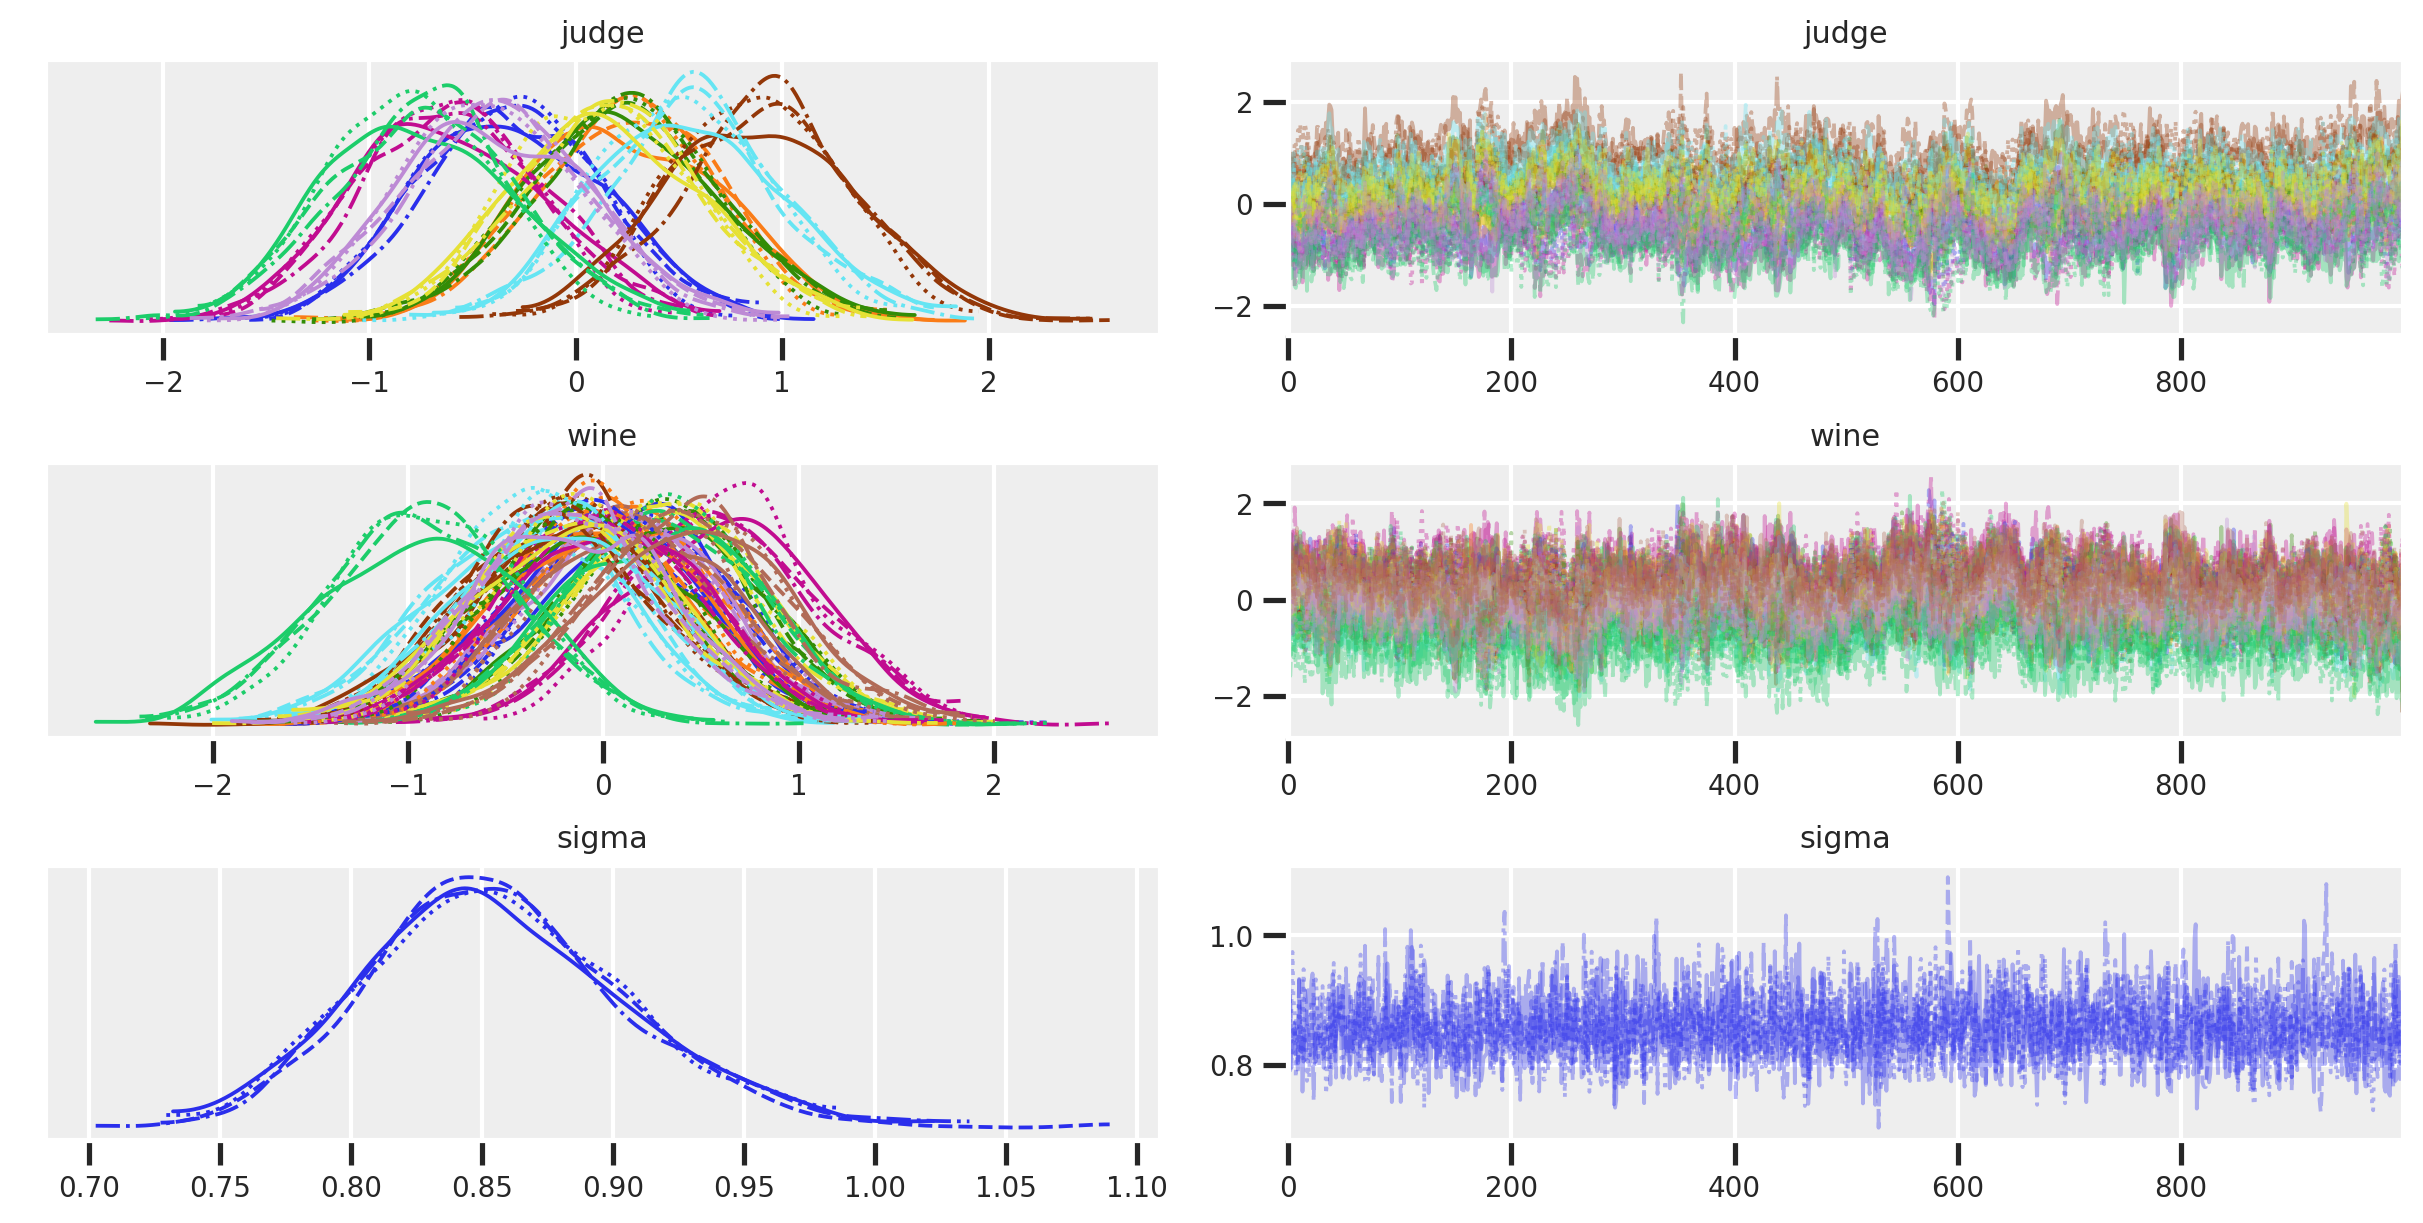

<IPython.core.display.Javascript object>

In [18]:
az.plot_trace(trace1)
# az.plot_trace(trace1, legend=True)   # looks too busy

Not sure we can really see separate chains here and diagnose.

### Prior predictive check 1a

Note that the `pm.sample_prior_predictive` call can be made outside the model generation step like this:

```
with wine_model1:
    priorpred_checks1 = pm.sample_prior_predictive(samples=100, random_seed=RANDOM_SEED)
```

In [19]:
# Inspect
priorpred_checks1

{'s': array([[ 1.12090367,  3.50058781,  0.98995091, ...,  4.72553372,
          6.04118137,  5.0705962 ],
        [ 7.67436336, -2.0982071 ,  2.01117079, ..., -3.73421801,
          0.49875935, -2.00329793],
        [ 2.62353879,  3.06077771,  7.70695558, ...,  1.33175674,
          2.20016263,  2.61881243],
        ...,
        [-0.28110319, -0.98920133,  1.69276601, ...,  0.09472086,
          0.04569195,  4.35506334],
        [ 1.65648534,  1.64603068,  1.85265175, ..., -1.07130701,
          3.00196585,  3.10129509],
        [-1.05572141,  3.83623106, -1.88305527, ...,  6.34646035,
          1.54786907,  2.54655438]]),
 'wine': array([[-0.58286427, -2.54066162,  1.83959757, ...,  1.347014  ,
          0.17345075,  0.4027031 ],
        [ 1.81107739, -1.2804476 , -0.46766769, ..., -0.18148598,
         -0.29340161, -2.18065636],
        [-1.53821228,  0.92266519, -1.26097678, ..., -0.55213524,
          0.28923131,  0.0570138 ],
        ...,
        [-0.50444373, -0.98914401, -1.629

<IPython.core.display.Javascript object>

In [20]:
priorpred_checks1["judge"][0]

array([-0.86898736,  4.77355434, -1.19324742,  1.61298887, -0.24634454,
        0.6599626 , -0.65758387,  1.04065417,  1.65667364])

<IPython.core.display.Javascript object>

In [21]:
len(priorpred_checks1["judge"][0])

9

<IPython.core.display.Javascript object>

In [22]:
len(priorpred_checks1["wine"][0])

20

<IPython.core.display.Javascript object>

In [23]:
len(priorpred_checks1["s"][0])

180

<IPython.core.display.Javascript object>

Note that for a single sample from the prior predictive distribution for judge, there's 9 values, one for each judge. For wine, there are 20 values, one for each wine. The number of scores in a single sample from the prior predictive distribution is 180 since it is all combinations of judges and wines. Since I expect the priors for the judges and wines to behave similarly, I'll simply choose the first of judge/wine/score to assess.

In [24]:
df_jws_prior1 = pd.DataFrame(
    {
        "judge": priorpred_checks1["judge"][:, 0],
        "wine": priorpred_checks1["wine"][:, 0],
        "score": priorpred_checks1["s"][:, 0],
    }
)
df_jws_prior1

,judge,wine,score
0,-0.868987,-0.582864,1.120904
1,1.972211,1.811077,7.674363
2,-1.526050,-1.538212,2.623539
3,-2.993149,1.835914,4.743450
4,-0.074410,3.923238,3.278704
...,...,...,...
95,1.562575,2.924679,1.703248
96,-1.484246,3.173545,3.707751
97,-0.408523,-0.504444,-0.281103
98,-1.859420,-0.556897,1.656485


<IPython.core.display.Javascript object>

/Users/blacar/opt/anaconda3/envs/stats_rethinking/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  self.fig.tight_layout(*args, **kwargs)


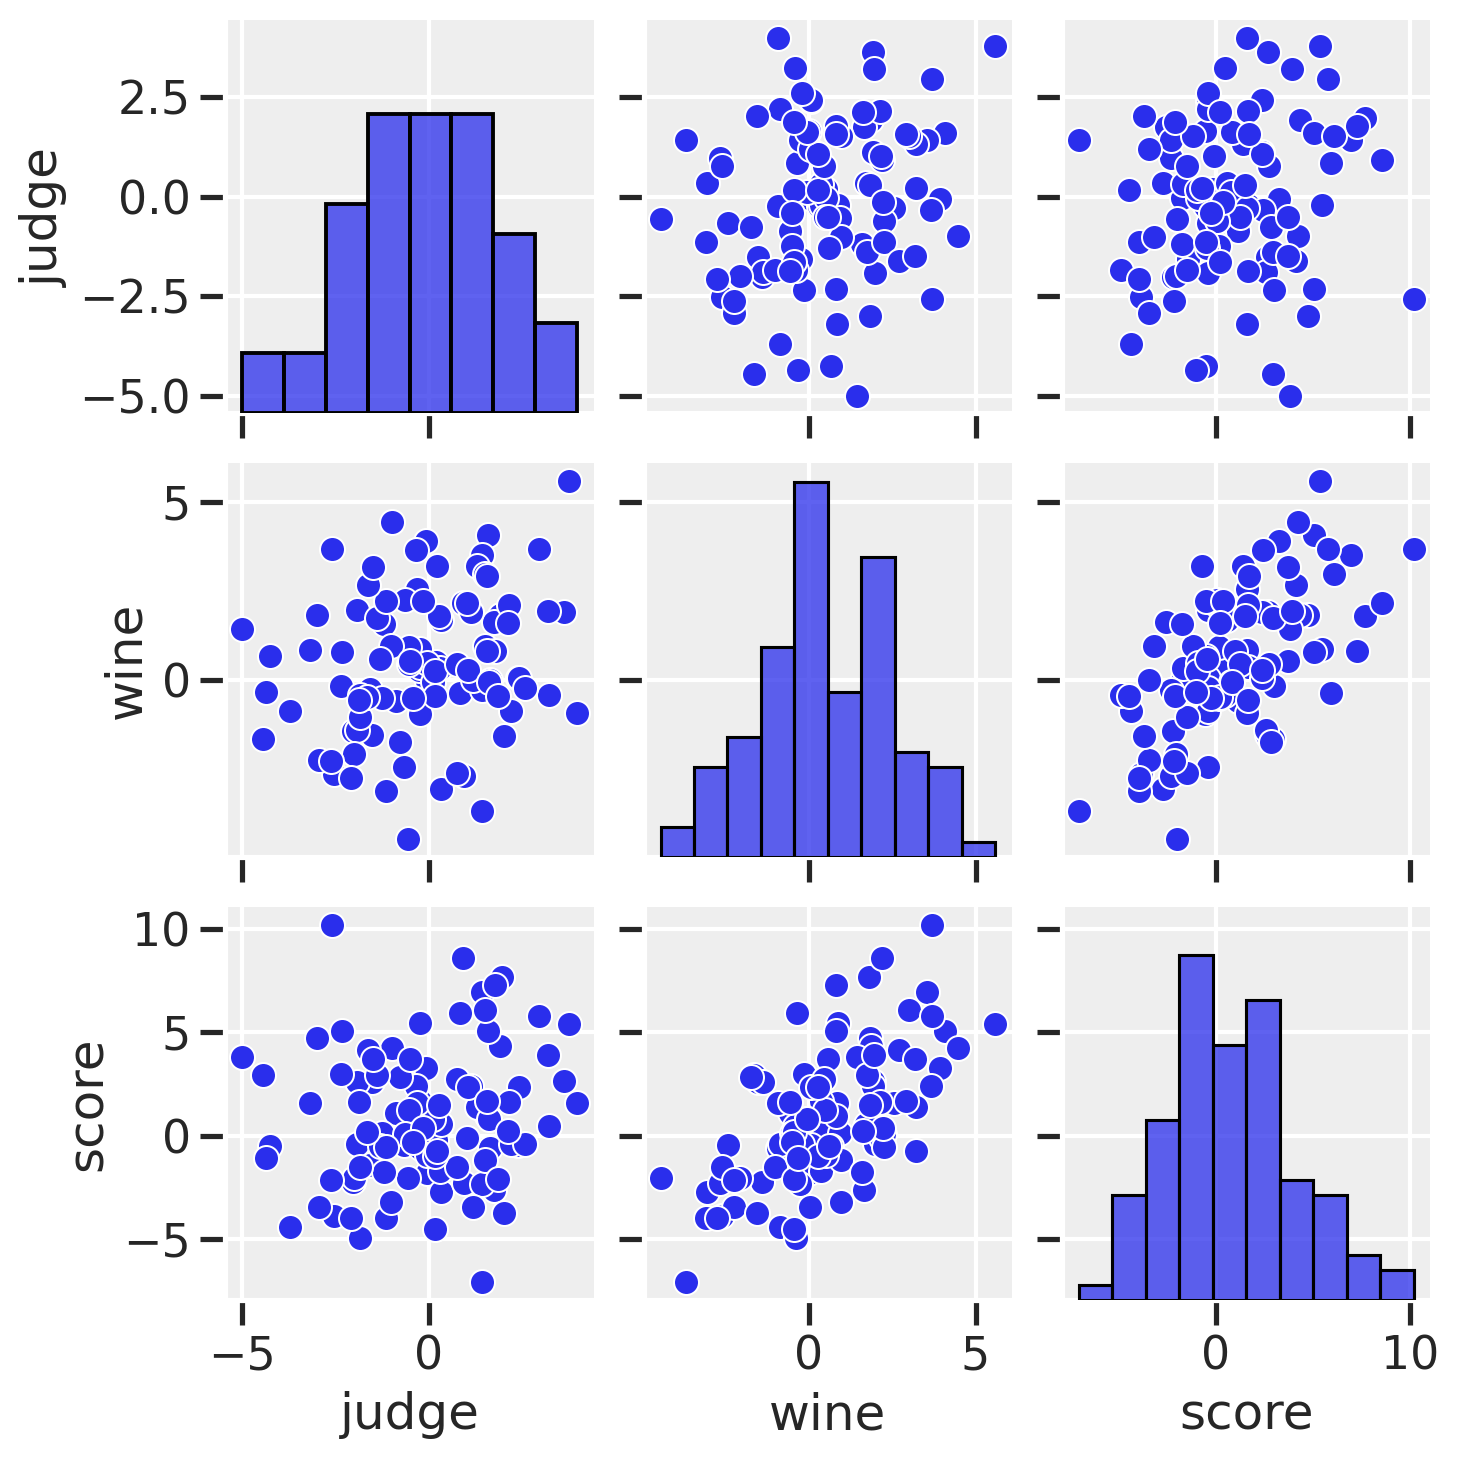

<IPython.core.display.Javascript object>

In [25]:
sns.pairplot(df_jws_prior1)

### Assessment of linear model 1a
My assessment of this is that there are still some values that are pretty far outside the expected range (> 2 standard deviations away). I'll make a new model with a tighter priors for both wine and judge.

Problems were also hinted by the warning that the number of effective samples was low for some parameters. In retrospect, we could have diagnosed at that point.

# Easy problems

8E1. For each of the causalrelationshipsbelow,nameahypotheticalthirdvariablethatwouldlead
toaninteractioneffect.

1. Bread dough rises because of yeast.
    - outcome: bread dough rising
    - predictor: 
    - (interacting) water, temperature, etc.
2. Education leads to higher income.
    - (interacting) Socio-political system of the country.
    - (interacting) Family status.
    - (independent) Experience would be an independent variable.
3. Gasoline makes a car go.
    - (interacting) flat tire
    - (interacting) bad fuel lines
    - (interacting with gasoline) outcome: how far car goes. aerodynamic profile of the car
    


8E2. Which of the following explanations invokes an interaction?

1. Caramelizing onions requires cooking over low heat and making sure the onions do not dryout.
    - Outcome: caramelizing onions 
    - Predictor with interaction: heat and moisture
    - conditional on onions not being dry
    
2. A car will go faster when it has more cylinders or when it has a better fuel injector.
    - Outcome: car will go faster
    - Predictors do not invoke interaction because of "or" ... more cylinders, conditional on a better fuel injector

3. Most people acquire their political beliefs from their parents, unless they get them instead from their friends.
    - Outcome: acquisition of political beliefs
    - Predictors: beliefs of parents, beliefs of friends
    - Not interaction because predictors don't depend on each other or don't influence each other

4. Intelligent animal species tend to be either highly social or have manipulative appendages (hands, tentacles, etc.).
    - Outcome: intelligent animal
    - Predictors: socialness, manipulative appendages
    - No interacdtion

8E3. For each of the explanations in 8E2, write a linear model that expresses the stated relationship.

## How do write interaction?

Two categorical example
```
m5.10 <-quap(
    alist(
        K ~dnorm(mu,sigma),
        mu <-a[clade_id]+h[house],
        a[clade_id] ~dnorm(0,0.5),
        h[house] ~dnorm(0,0.5),
        sigma ~dexp(1)
        ) ,data=d)
```

How are index variables coded in pymc?
- index variables.... start with 0 or start with 1?

8M1. Recall the tulips example from the chapter. Suppose another set of treatments adjusted the temperature in the greenhouse over two levels: cold and hot. The datainthechapterwerecollected
atthecoldtemperature.Youfindnoneoftheplantsgrownunderthehottemperaturedeveloped
anybloomsatall,regardlessofthewaterandshadelevels.Canyouexplainthisresultintermsof
interactionsbetweenwater,shade,andtemperature?



outcome: growth
predictor: water, shade, temp

```
blooms_std ~dnorm(mu, sigma)
mu <- a + bw*water_cent + bs*shade_cent + bT*temp_cent 
      + bWS*water_cent*shade_cent
      + bWT*water_cent*temp_cent
      + bST*shade_cent*temp_cent
      + bWST*water_cent*shade_cent*temp_cent

# how to edit so blooms goes to zero if temp is too hot
```

8M3




In [ ]:
a and b hav two categories
a[1], a[2], b[1], b[2]


mu = a[i] + b[i]  # no interaction
mu = a[i] + b[i] + a[i]*b[i] # ?? with interaction


mu = a[i] + b[j] + a[i,j] + b[i,j] # Matthew?? with interaction

## bottom

Appendix: Environment and system parameters

In [3]:
%watermark -n -u -v -iv -w

Last updated: Wed May 26 2021

Python implementation: CPython
Python version       : 3.8.6
IPython version      : 7.20.0

scipy     : 1.6.0
pandas    : 1.2.1
arviz     : 0.11.1
json      : 2.0.9
matplotlib: 3.3.4
pymc3     : 3.11.0
seaborn   : 0.11.1
numpy     : 1.20.1

Watermark: 2.1.0



<IPython.core.display.Javascript object>